# 01-01: Analisi distribuzione Dirichlet

**1.1 Generare un vettore $(X_1, ..., X_n)$ di dimensione $n=10$ con legge di Dirichlet di parametro α=0.5 (uguale per tutte le componenti). Sia Y il valore massimo delle componenti $Y=max_i X_i$. Studiare la distribuzione di Y con una simulazione MC.
È richiesto di stimarne media e varianza, con intervalli di confidenza, di visualizzare la distribuzione con istogramma, kde, cdf empirica.**

In [1]:
from scipy.stats import dirichlet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n_samples = 1000
dim = 10
alpha = [0.5] * dim

In [3]:
samples = dirichlet.rvs(alpha=alpha, size=n_samples)
samples.shape

(1000, 10)

In [4]:
y = np.max(samples, axis=1)
y.shape

(1000,)

In [5]:
from scipy.stats import t
import numpy as np

conf = 0.95
alpha = 1 - conf

n = len(y)
mean = np.mean(y)
s = np.std(y, ddof=1)          # deviazione standard campionaria
df = n - 1

q = t.ppf(1 - alpha/2, df)     # quantile critico t

margin = q * s / np.sqrt(n)

ci_low  = mean - margin
ci_high = mean + margin

print(f"IC {conf:.0%} per la media: [{ci_low:.6f}, {ci_high:.6f}]")

IC 95% per la media: [0.369043, 0.383501]


In [6]:
from scipy.stats import chi2
import numpy as np

conf = 0.95
alpha = 1 - conf

n = len(y)
s2 = np.var(y, ddof=1)          # varianza campionaria
df = n - 1

q_low  = chi2.ppf(alpha/2, df)        # quantile basso
q_high = chi2.ppf(1 - alpha/2, df)    # quantile alto

ci_low  = df * s2 / q_high
ci_high = df * s2 / q_low

print(f"IC {conf:.0%} per la varianza: [{ci_low:.6f}, {ci_high:.6f}]")
print(f"IC {conf:.0%} per la std: [{np.sqrt(ci_low):.6f}, {np.sqrt(ci_high):.6f}]")

IC 95% per la varianza: [0.012455, 0.014844]
IC 95% per la std: [0.111601, 0.121835]


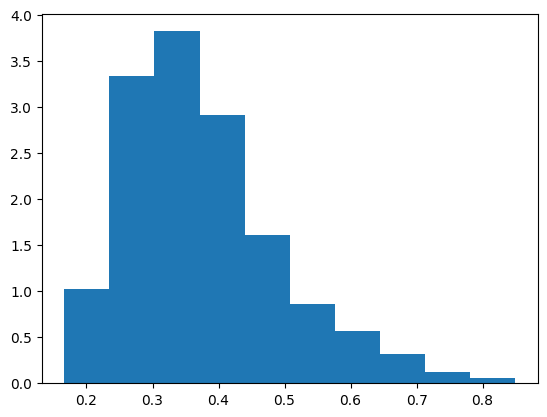

In [7]:
plt.hist(y, density=True)
plt.show()

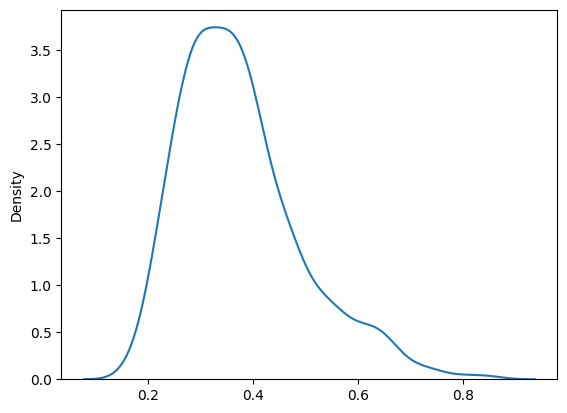

In [8]:
sns.kdeplot(y)
plt.show()

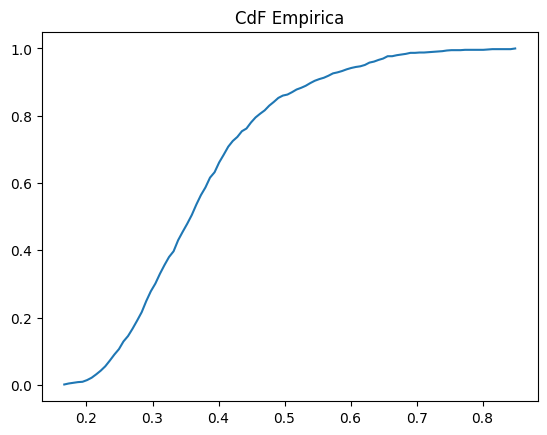

In [9]:
def ecdf(val, Y_sorted):
  return np.sum(Y_sorted <= val) / len(Y_sorted)

y_sorted = sorted(y)
ecdf_x = np.linspace(min(y_sorted), max(y_sorted), 100)
ecdf_y = []

for val in ecdf_x:
  ecdf_y.append(ecdf(val, y_sorted))

plt.plot(ecdf_x, ecdf_y)
plt.title("CdF Empirica")
plt.show()

**1.2 Testare se la legge di Y può essere considerata approssimativamente Gaussiana sia graficamente, sia con un test di adattamento.**

Qui stiamo applicando un **test di adattamento chi-quadro** per verificare se la variabile $Y$può essere considerata approssimativamente **Gaussiana**.

Prima facciamo un controllo **grafico**

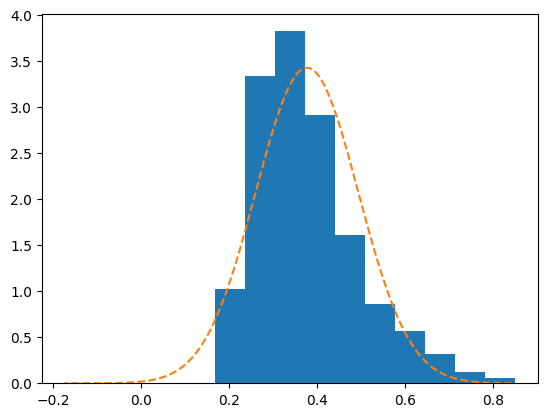

In [10]:
from scipy.stats import norm

mean = y.mean()
std = y.std(ddof=1)

x_norm = np.linspace(mean + (4*std), mean * (-4*std),n_samples)
y_norm = norm.pdf(x_norm, loc=mean, scale=std)

plt.hist(y, density=True)
plt.plot(x_norm, y_norm, "--")
plt.show()

Questo codice costruisce un **Q-Q plot** (quantile-quantile plot) per confrontare la distribuzione empirica dei dati `x` con una **Normale stimata** sugli stessi dati.

All'inizio ordini i dati con `np.sort(x)`: così ottieni i **quantili campionari**, cioè i valori osservati messi in ordine crescente. Ogni posizione nell'array ordinato corrisponde a un quantile empirico.

Poi costruisci `p`, che sono le **plotting positions**. L'espressione `(i - 0.5) / n` assegna a ciascun punto una probabilità compresa tra 0 e 1, evitando esattamente 0 e 1. Questo serve perché i quantili teorici della normale in 0 e 1 sarebbero ±∞.

Con `norm.ppf(p, loc=mean, scale=std)` calcoli i **quantili teorici** della distribuzione Normale con media `mean` e deviazione standard `std`, stimati dal campione. In pratica stai chiedendo: “se i dati fossero davvero Normali(mean, std), quali valori mi aspetterei a queste probabilità?”

Nel grafico metti sull'asse x i quantili teorici e sull'asse y quelli campionari. Ogni punto confronta un quantile osservato con il quantile che la normale predirebbe.

La retta `y = x` è una linea di riferimento: se i punti stanno circa su questa retta, significa che i quantili empirici coincidono con quelli teorici e quindi la normalità è plausibile. Deviazioni sistematiche dalla retta indicano scostamenti dalla normalità (curvatura → code diverse, asimmetria → skewness).

In sintesi: il Q-Q plot è un controllo grafico molto diretto per valutare se i dati possono essere considerati approssimativamente Gaussiani.

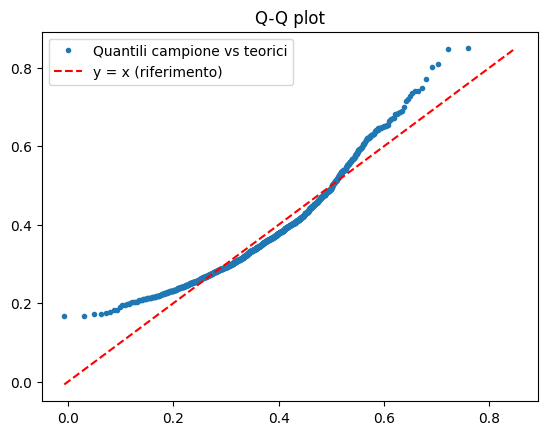

In [11]:
y_sorted = np.sort(y)                               # quantili campionari
p = (np.arange(1, n+1) - 0.5) / n                   # plotting positions (evita 0 e 1)
q_theory = norm.ppf(p, loc=mean, scale=std)         # quantili teorici Normale(mean, std)

mn = min(q_theory[0], y_sorted[0])
mx = max(q_theory[-1], y_sorted[-1])

plt.plot(q_theory, y_sorted, '.', label="Quantili campione vs teorici")
plt.plot([mn, mx], [mn, mx], 'r--', label="y = x (riferimento)")
plt.title("Q-Q plot")
plt.legend()
plt.show()

Poi passiamo al test formale. Stimiamo media $\mu$ e deviazione standard $\sigma$ dal campione e costruiamo una distribuzione normale $N(\mu, \sigma^2)$. Usando questa normale, dividiamo l'asse reale in $k = 5$ intervalli **equiprobabili** sotto l'ipotesi di normalità, calcolando i quantili ai livelli $1/k, 2/k, \dots$

Contiamo quante osservazioni cadono in ciascun intervallo: queste sono le **frequenze osservate**. Se i dati fossero davvero normali, ci aspetteremmo circa $n/k$ osservazioni in ogni classe: queste sono le **frequenze attese**.

La statistica chi-quadro misura quanto le frequenze osservate si discostano da quelle attese. Poiché media e varianza sono stimate dai dati, il test usa una correzione dei gradi di libertà ($ddof = 1$).

Se il p-value del test è piccolo, rifiutiamo l'ipotesi che $Y$ segua una distribuzione normale. Se invece è grande, non abbiamo evidenza contro la normalità, in accordo (o meno) con quanto osservato nei grafici.

In [14]:
import numpy as np
from scipy.stats import norm, chisquare

mu = y.mean()
sigma = y.std(ddof=1)  # meglio ddof=1 come stima campionaria
k = 5

di = norm(loc=mu, scale=sigma)

# bordi ai quantili 1/k, 2/k, ..., (k-1)/k, con estremi infiniti
edges = di.ppf(np.arange(1, k) / k)
edges = np.r_[-np.inf, edges, np.inf]

obsg, _ = np.histogram(y, bins=edges)

# frequenze attese: n/k per ogni classe (equiprobabili sotto H0 "normale stimata")
n = len(y)
expg = np.full(k, n / k)

statistic, pvalue = chisquare(obsg, f_exp=expg, ddof=2)
print(f"Statistic: {statistic}")
print(f"P-value: {pvalue}")

Statistic: 43.56
P-value: 3.4758912812399184e-10
